In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table, join, Column

from astropy.io import ascii
import glob, re

% matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')

#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=18               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
from matplotlib import rc

colours = mpl.rcParams['axes.color_cycle'] 


/Users/benjaminpope/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:830: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


## This notebook reads in Keith's abundances and Guy's asteroseismology to produce the tables for the paper.

In [2]:
fname_diff = "../data/abundances/Pope_abundances_diff_arcturus.fits"
fname_nodiff = "../data/abundances/Pope_abundances_nodiff.fits"

In [3]:
diff = Table.read(fname_diff)
diff.sort('Object')
nodiff = Table.read(fname_nodiff)
nodiff.sort('Object')

How do abundances compare between the differential and non-differential methods? Not too badly. Many more elements lack differential abundances than absolute abundances so it looks like in the paper we shouldn't use the differential. Good to include in online data though.

In [4]:
# for j, key in enumerate(diff.keys()[1:]):
#     if key[0]=='e':
#         continue
#     plt.figure(j)
#     plt.plot(diff[key],nodiff[key],'.')
#     plt.title(key)

In [5]:
nodiff

Object,Ca_Fe,eCa_Fe,Mg_Fe,eMg_Fe,Si_Fe,eSi_Fe,Ti_Fe,eTi_Fe,O_Fe,eO_Fe,Al_Fe,eAl_Fe,Ba_Fe,eBa_Fe,Na_Fe,eNa_Fe,Ni_Fe,eNi_Fe,Mn_Fe,eMn_Fe,Co_Fe,eCo_Fe,Eu_Fe,eEu_Fe,La_Fe,eLa_Fe,Zr_Fe,eZr_Fe,Sr_Fe,eSr_Fe,Zn_Fe,eZn_Fe,Y_Fe,eY_Fe,Cr_Fe,eCr_Fe,V_Fe,eV_Fe,Cu_Fe,eCu_Fe,Sc_Fe,eSc_Fe
str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
BD+36_3564,0.20550000000000068,0.021811959427664313,0.32699999999999996,0.029981933288751386,0.1030000000000002,0.03033791174238739,0.3414999999999999,0.039563195412588896,nan,nan,0.39749999999999996,0.008838834764831969,nan,nan,0.2600000000000007,0.07726769244837267,0.006000000000000227,0.04284999081677555,0.07750000000000057,0.0045961940777125235,0.1299999999999999,0.023192941522005114,0.24799999999999933,0.02768573639981425,-0.016499999999999737,0.0659359300760974,0.10200000000000031,0.021922773547158676,0.3440000000000003,0.11825713509129157,-0.28699999999999903,0.19772933239377738,-0.2739999999999996,0.015773296262988193,0.23000000000000043,0.003797614382740828,0.1535000000000002,0.03049898435435564,-0.04499999999999971,0.06190150947270998,0.17300000000000093,0.017790381816734174
BD+39_3577,0.1330000000000009,0.024249415323230328,0.2150000000000003,0.03658925303282372,-0.10549999999999926,0.02174089847882709,0.08499999999999996,0.03879026485998592,nan,nan,0.20550000000000024,0.00954594154601844,0.3520000000000003,0.1010273157048059,0.41600000000000037,0.0,-0.051000000000000156,0.03328029088036782,-0.028999999999999027,0.05782989102787844,-0.015999999999999126,0.02072659732649556,-0.22100000000000009,0.04160228359116841,-0.254999999999999,0.015035759843588615,0.128000000000001,0.08221016968721083,nan,nan,-0.24099999999999877,0.7076482176901175,-0.4039999999999999,0.037289656991162025,0.1640000000000006,0.0952853444922145,0.010500000000000398,0.020276010901452025,-0.20599999999999952,0.012727922061357708,-0.12499999999999956,0.053405093390050375
BD+43_3064,0.18600000000000083,0.042992624259758146,0.2110000000000003,0.03401960219246152,-0.013999999999999346,0.030231207814540438,0.28249999999999975,0.044954827587674044,nan,nan,0.3550000000000004,0.010606601717797986,nan,nan,0.4790000000000001,0.06424951361683594,0.052999999999999936,0.044591812612475384,0.21400000000000086,0.024748737341528947,0.1330000000000009,0.02184520148655853,0.28000000000000025,0.05847007781763251,0.14950000000000063,0.017140503930748237,0.3230000000000004,0.03883977342879325,0.24800000000000022,0.12460813576970005,nan,nan,-0.13999999999999968,0.051714601419715026,0.32200000000000095,0.013075280607427315,0.24100000000000055,0.034289644203321076,-0.15899999999999936,0.09666551723454563,0.13700000000000045,0.024837935349126893
BD+43_3171,0.28550000000000075,0.027774123216385355,0.2570000000000001,0.06383866383313486,-0.0004999999999997229,0.06954906181969671,0.20650000000000013,0.05828622108614094,nan,nan,0.4225000000000003,0.012968712349342808,0.32650000000000023,0.17867480936046912,0.18350000000000044,0.24711535767734086,0.04100000000000037,0.05452977168483287,0.1095000000000006,0.0947523086789976,0.1385000000000005,0.05128187695268264,0.2134999999999998,0.04800520805079382,-0.057999999999999385,0.11110636795431662,0.3585000000000007,0.06505382386916242,nan,nan,-0.40499999999999936,0.05055813485483807,-0.3059999999999996,0.030052038200428254,0.2940000000000005,0.03995153313703977,0.12350000000000039,0.056319659089877294,0.017000000000000348,0.10812319362652953,0.1435000000000004,0.032129667788764645
BD+43_3213,0.1880000000000006,0.02661522816679147,0.22599999999999998,0.07206097859790929,-0.1779999999999995,0.11026558846711877,0.2709999999999999,0.06893329102190833,nan,nan,0.37200000000000033,0.038890872965260226,nan,nan,0.6230000000000002,0.367428

In [6]:
elements = filter(lambda x: x[0]!='e', nodiff.keys()[1:])
print elements

['Ca_Fe', 'Mg_Fe', 'Si_Fe', 'Ti_Fe', 'O_Fe', 'Al_Fe', 'Ba_Fe', 'Na_Fe', 'Ni_Fe', 'Mn_Fe', 'Co_Fe', 'Eu_Fe', 'La_Fe', 'Zr_Fe', 'Sr_Fe', 'Zn_Fe', 'Y_Fe', 'Cr_Fe', 'V_Fe', 'Cu_Fe', 'Sc_Fe']


### Create a string-formatted table merging abundances with their uncertainties appropriately.

In [7]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[:8]:
    if el == 'O_Fe':
        continue
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab.add_column(test)
    
#     print el


newtab2 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[8:15]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab2.add_column(test)
    
newtab3 = Table([Column([str(obj).replace('_',' ') for obj in nodiff['Object']],name='Object')])

for el in elements[15:]:
    col = nodiff[el]
    ecol = nodiff['e%s' % el]
    test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name='[%s/Fe]' % el.replace('_Fe',''))
#     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

    newtab3.add_column(test)

    
# newtab_diff = Table([diff['Object']])

# for el in elements:
#     col = diff[el]
#     ecol = diff['e%s' % el]
#     test = Column(['--' if 'nan' in str(col[j]) else '%.2f $\pm$ %.2f' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))
# #     test = Column(['$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=el.replace('_Fe',''))

#     newtab_diff.add_column(test)


In [8]:
def oxford_join(string_list):
    '''From https://stackoverflow.com/questions/19838976/grammatical-list-join-in-python'''
    if len(string_list) < 1:
        text = ''
    elif len(string_list) == 1:
        text = string_list[0]
    elif len(string_list) == 2:
        text = ' and '.join(string_list)
    else:
        text = ', '.join(string_list)
        text = '{parts[0]}, and {parts[2]}'.format(parts=text.rpartition(', '))  # oxford comma
    return text

## Now produce three LaTeX tables to go into the paper directory.

In [9]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'

caption1 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in filter(lambda x: x !='O_Fe',elements[0:8])])
caption2 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[8:15]])
caption3 = r'Chemical abundances relative to iron for stars in the red giant sample as determined by BACCHUS, without differential line-by-line comparison to Arcturus, as described in Section~\ref{spectroscopy}, for the elements %s. Dashes indicate elements for which abundances could not be reliably computed.' % oxford_join([el.replace('_Fe','') for el in elements[15:]])

caption1 = caption1+r'The catalogue of abundances for more elements continues in Tables~\ref{elems2} and~\ref{elems3}.'
caption2 = caption2+r'The catalogue of abundances for more elements continues in Table~\ref{elems3}.'


newtab.write('../paper/abundances_1.tex',format='latex',latexdict=latexdict,caption=caption1+'\label{elems1}',overwrite=True)
newtab2.write('../paper/abundances_2.tex',format='latex',latexdict=latexdict,caption=caption2+'\label{elems2}',overwrite=True)
newtab3.write('../paper/abundances_3.tex',format='latex',latexdict=latexdict,caption=caption3+'\label{elems3}',overwrite=True)

### Now let's also do the stellar properties

In [10]:
fname_merged ="../data/abundances/final_pope_merged.fits"
merged = Table.read(fname_merged)
merged.rename_column('RVerr','RV_err')
merged.keys()
merged.sort('Object')

In [11]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in merged['Object']],name='Object')])

newkeys = ['RV', 'Teff', 'logg', 'monh','vsini','SNRe']
names = [r'RV',r'\teff', r'\logg',r'[M/H]',r'$V\sin{i}$',r'SNR']
units = [r'(km/s)', r'(K)', '','','(km/s)','']

for k, key in enumerate(newkeys):
    col = merged[key]
    if key+'_err' in merged.keys():
        ecol = merged['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)


In [12]:
newtab

Object,RV,\teff,\logg,[M/H],$V\sin{i}$,SNR
str10,str17,str13,str15,str16,str16,str5
BD+36 3564,$-77.84 \pm 0.05$,$4301 \pm 50$,$2.06 \pm 0.10$,$-0.34 \pm 0.08$,$5.14 \pm 0.50$,71.8
BD+39 3577,$-14.81 \pm 0.07$,$5079 \pm 50$,$3.00 \pm 0.10$,$-0.11 \pm 0.08$,$3.98 \pm 0.50$,92.8
BD+43 3064,$-13.65 \pm 0.06$,$4266 \pm 50$,$2.03 \pm 0.10$,$-0.21 \pm 0.08$,$5.17 \pm 0.50$,69.2
BD+43 3171,$-16.32 \pm 0.11$,$4072 \pm 50$,$2.02 \pm 0.10$,$-0.17 \pm 0.08$,$5.68 \pm 0.50$,68.6
BD+43 3213,$-14.16 \pm 0.16$,$4131 \pm 50$,$2.07 \pm 0.10$,$0.07 \pm 0.08$,$6.24 \pm 0.50$,57.3
BD+48 2955,$1.66 \pm 0.04$,$4344 \pm 50$,$2.11 \pm 0.10$,$-0.32 \pm 0.08$,$4.78 \pm 0.50$,31.7
HD 174020,$-14.84 \pm 0.08$,$4162 \pm 50$,$1.97 \pm 0.10$,$-0.10 \pm 0.08$,$5.81 \pm 0.50$,120.1
HD 174829,$10.15 \pm 0.03$,$4482 \pm 50$,$2.06 \pm 0.10$,$-0.40 \pm 0.08$,$4.41 \pm 0.50$,112.2
HD 175740,$-8.82 \pm 0.05$,$4973 \pm 50$,$2.97 \pm 0.10$,$-0.05 \pm 0.08$,$3.66 \pm 0.50$,264.0


In [13]:
latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))

caption = r'Fundamental stellar parameters for the red giant sample as determined jointly by asteroseismology (asteroseismic \logg; Section~\ref{asteroseismology}) and spectroscopy (%s; Section~\ref{spectroscopy}.)' % oxford_join(names)  
caption = caption+r'\label{stellar_props}'
newtab.write('../paper/stellar_props.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Now let's look at the proper spectroscopy with Dnu measurements

In [14]:
fname_seismic = "../data/smear_Dnu.csv"
seismic = Table.read(fname_seismic)
seismic.sort('Star_ID')

In [15]:
seismic

Star_ID,Dnu,Dnu_err,Numax,Numax_err,eps,eps_err
str9,float64,float64,float64,float64,float64,float64
BD+36_356,0.9490949804411055,0.030097283743239316,5.079062736733746,0.09882652247868091,0.8305746287171062,0.20003026391376488
BD+39_357,1.6836250688792482,0.01363988821142889,13.266855807051439,0.31633186319569034,0.7409609522947077,0.06299253167276896
BD+42_315,4.221788591943251,0.028504804862306103,38.315943379269186,0.9588694546996247,0.7013731801198373,0.07075600621249865
BD+43_317,0.41728859981040545,0.05318387492844148,1.984298734336489,0.05145104900196677,0.8040170562496404,0.17159665699501567
BD+43_321,0.48750734592283734,0.006958633078022336,2.5632797174106847,0.06325084146747773,1.0124195735754942,0.07326685394355063
BD+48_290,2.8511597676805804,0.010318892608438912,23.13453453354469,0.7225398099392429,0.8563054208127122,0.08052669688943252
BD+48_295,0.8953098233940573,0.0068208356847463585,5.440132725276065,0.08331498484403516,0.8105480979445374,0.052471147709803705
HD_174020,0.5639183284003043,0.01603666749035637,2.47548965209216,0.09744999575175439,0.8926590744791576,0.08467569516842773
HD_174829,1.2833572675283929,0.011357043983480081,7.9497984768617815,0.1571667547811646,0.7755393571480604,0.05755641850899791


In [16]:
newtab = Table([Column([str(obj).replace('_',' ') for obj in seismic['Star_ID']],name='Object')])

newkeys = ['Dnu', 'Numax', 'eps']
names = [r'\Dnu',r'\numax', r'$\epsilon$']
units = [r'(\muHz)', r'(\muHz)','']

for k, key in enumerate(newkeys):
    col = seismic[key]
    if key+'_err' in seismic.keys():
        ecol = seismic['%s_err' % key]
        if 'Teff' in key:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.0f \pm %.0f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
        else:
            test = Column(['--' if 'nan' in str(col[j]) else '$%.2f \pm %.2f$' % (col[j],ecol[j]) for j, x in enumerate(col)],name=names[k])
    else:
        test = Column(['%.1f' % (col[j]) for j, x in enumerate(col)],name=names[k])
    
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table'
latexdict['units'] = dict(zip(names,units))

caption = r'Bulk asteroseismic parameters %s for the red giant sample as discussed in Section~\ref{asteroseismology}.' % oxford_join(names)  
caption = caption+r'\label{astero_table}'
newtab.write('../paper/astero_table.tex',format='latex',latexdict=latexdict,caption=caption+'\label{stellar_props}',overwrite=True)


### Notes on individual stars from Guy Davies

BD+39_388 - No secure detection.

BD+43_306 - Big peaks but not consistent enough with RG pattern.

HD_179959 - Pattern is too complicated - is this two stars??  Literature says no.

HD_185351 - Odd mode envelope - No explanation.

HD_187217 - No info on this star - maybe a double but very difficult to tell.

HD_188639 - Too difficult to get a robust Dnu.

HD_188875 -  Too difficult to get a robust Dnu.

HD_188629 - Too difficult to get a robust Dnu.



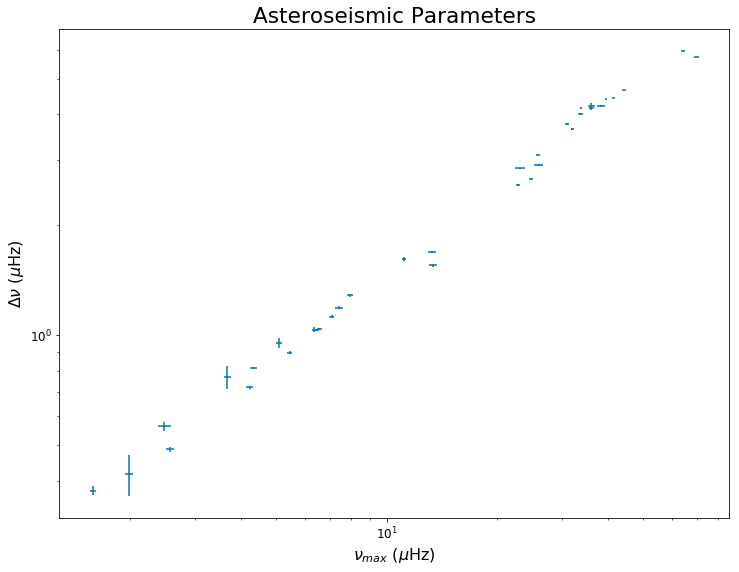

In [17]:
# the stars follow the expected numax-Dnu relation
plt.errorbar(seismic['Numax'],seismic['Dnu'],xerr=seismic['Numax_err'],yerr=seismic['Dnu_err'],linestyle='none')
plt.xlabel(r'$\nu_{max}$ ($\mu$Hz)')
plt.ylabel(r'$\Delta\nu$ ($\mu$Hz)')
plt.title('Asteroseismic Parameters')
plt.xscale('log')
plt.yscale('log')

### Which ones are missing?

In [18]:
badstars = ['BD+39_388','BD+43_306','HD_179959','HD_185351','HD_187217','HD_188639','HD_188875','HD_188629']
notes = ['No secure detection','Not consistent with RG pattern','Possible contamination',r'\citep{2017MNRAS.464.3713H}',
         'Possible contamination or binary',r'Too difficult to get a robust \Dnu',r'Too difficult to get a robust \Dnu',
         r'Too difficult to get a robust \Dnu']

notecol = [notes[j] if star in badstars else '' for j, star in enumerate(seismic['Star_ID'])]

In [19]:
np.sort(badstars)

array(['BD+39_388', 'BD+43_306', 'HD_179959', 'HD_185351', 'HD_187217',
       'HD_188629', 'HD_188639', 'HD_188875'], dtype='|S9')

In [20]:
for star in merged['Object']:
    if star[:9] not in seismic['Star_ID']:
        print star[:9]

BD+43_306
HD_179959
HD_185351
HD_187217
HD_188629
HD_188875


In [21]:
for star in seismic['Star_ID']:
    if star not in merged['Object'].astype('S9'):
        print star

BD+42_315
BD+48_290
HD_176209
HD_182354
HD_189636
HD_189750


## Read the main catalogue

In [22]:
fname_cat = '../data/catalogue.csv'
cat = Table.read(fname_cat,format='ascii')
cat.sort('kepmag')

In [23]:
cat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
HD_185351,G9IIIbCN,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--
HD_187372,M1III,--,2.693,unobserved,4,--,--,--,7.805,6.141,2.979,5.672,110,RG: low freq,--,--,--
HD_182694,G7IIIa,-0.01,0.771,LC:Q2 under,4,--,--,--,6.76,5.86,4.437,5.722,137,RG,Tim W,Yes,--
V380_Cyg,B1.1III+B2.5/3V,1.25,0.226,LC:Q11 SC:Q7 9 10 12-17 under,4,--,--,--,5.615,5.675,5.712,5.771,122,Eclipsing_binary,--,--,--


In [24]:
print 'Clump Candidates:',oxford_join([name.replace('_',' ') for name in cat[np.array(['clump' in thing for thing in list(cat['Notes'].data.data[:])])]['Name']])

Clump Candidates: HD 181069, HD 182354, HD 183124, HD 182692, and HD 180658


### Now to get SIMBAD queries

In [25]:
from astroquery.simbad import Simbad
from astropy import coordinates as coord
from astropy import units as u


In [26]:
Simbad.reset_votable_fields()
Simbad.add_votable_fields('sptype')
sim = Simbad.query_objects(cat['Name'])
sim.write('smear_intermediate.csv',overwrite=True)
sim = Table.read('smear_intermediate.csv')
c = coord.SkyCoord(ra=sim['RA'], dec=sim['DEC'],unit=(u.hourangle, u.deg), frame='icrs')


In [27]:
new = Table([Column([cc.ra.deg for cc in c],name='RA',unit='deg',description='RA'),Column([cc.dec.deg for cc in c],name='Dec',unit='deg',description='Dec')],masked=False)
new.write('smear_simbad.csv')

We then use the gaia tap service at http://gaia.ari.uni-heidelberg.de/tap.html for crossmatch 
using the command

SELECT bj.source_id, sm.ra, sm.dec, sm.phot_g_mean_mag, bj.r_est, bj.r_lo, bj.r_hi
FROM gaiadr2_complements.geometric_distance as bj 
JOIN TAP_UPLOAD.smear AS sm ON sm.source_id = bj.source_id

In [28]:
dists = Table.read('../data/gaia_dists.csv')
# V2083_Cyg doesn't have a parallax
dists.insert_row(38,
                 vals={'source_id':2128480311802353536,'ra':292.818076238,'dec':47.481042633,
                       'phot_g_mean_mag':6.81,'r_est':np.nan,'r_lo':np.nan,'r_hi':np.nan})

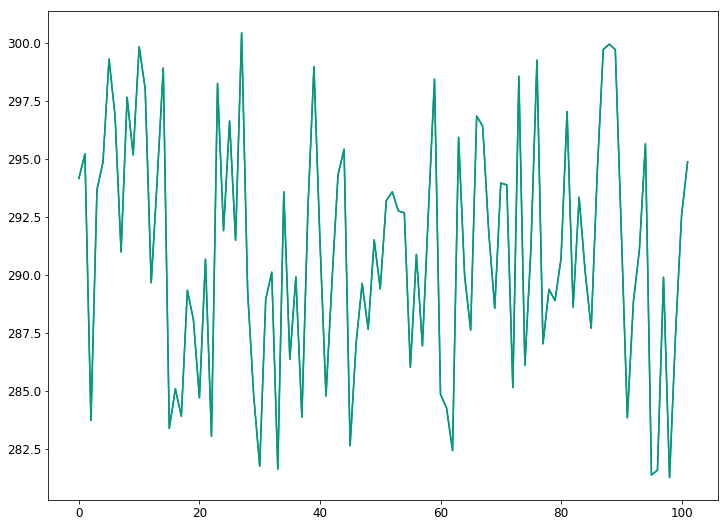

In [29]:
plt.plot(new['RA'])
plt.plot(dists['ra'])
# plt.xlim(35,45)

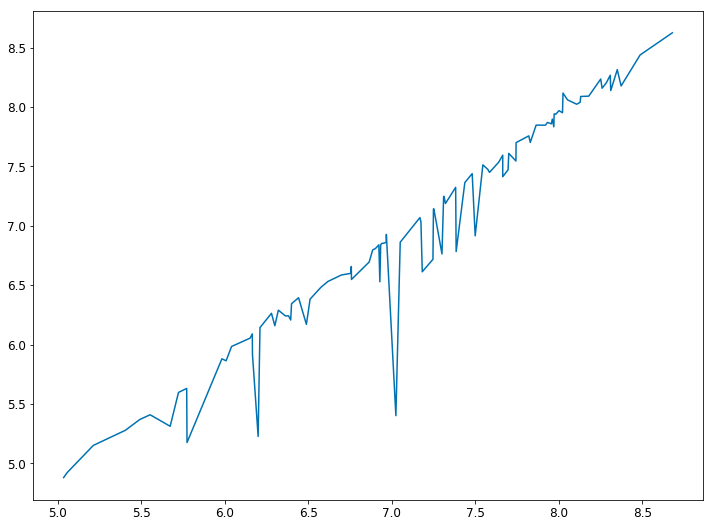

In [30]:
plt.plot(cat['kepmag'],dists['phot_g_mean_mag'])

In [31]:
cat[np.abs(dists['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?
str10,str15,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3
V547_Lyr,M4IIIa,--,--,unobserved,4,--,--,--,8.109,6.611,2.258,6.199,48,RG: low freq,--,--,--
V398_Lyr,M3,--,--,unobserved,4,--,--,--,8.877,7.421,1.869,7.024,49,RG,--,--,--


In [32]:
dists[np.abs(dists['phot_g_mean_mag']-cat['kepmag'])>0.75]#.sort(np.abs(dists['phot_g_mean_mag']-cat['kepmag']))

source_id,ra,dec,phot_g_mean_mag,r_est,r_lo,r_hi
int64,float64,float64,float64,float64,float64,float64
2103815448491466496,285.0794350340927,40.683934166877044,5.227579,288.920092314708,276.921626546759,301.985143696241
2100382189073830528,287.05494859817054,39.154894446731085,5.4027195,494.665556977779,464.050015806101,529.522722362535


In [33]:
# sim

In [34]:
newcat = cat.copy()
newcat['SpType']=sim['SP_TYPE']
for col in dists.columns:
    newcat.add_column(dists[col])

In [84]:
# for l, ccat in enumerate([cat[:52],cat[52:]]):

#     newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

#     newkeys = ['SpType','kepmag', 'Observed', 'Seasons','TRES?']
#     names = [r'Spectral Type',r'$Kp$', r'Observed',r'Seasons','Spectroscopy']
#     units = [r'(SIMBAD)', r'(mag)','','','']

#     for k, key in enumerate(newkeys):
#         col = ccat[key]
#         if 'bs' in key:
#             test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
#         elif key != 'TRES?':
#             test = Column(col.data,name=names[k])
#         if key == 'TRES?':
#             test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
#         newtab.add_column(test)
    
#     latexdict = ascii.latex.latexdicts['AA'].copy()
#     latexdict['tabletype']= 'table*'
#     latexdict['units'] = dict(zip(names,units))
#     if l == 0:
#         caption = r'The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Some objects, such as HD 185351, were observed in long cadence in some quarters and short cadence in others, and this is noted accordingly.' 
#         caption = caption+r'\label{all_stars}'
#         newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
#         print 'Written %s' % '../paper/all_stars.tex'
#     else:
#         latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue.  \label{all_stars_cont}}'
#         newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
#         print 'Written %s' % '../paper/all_stars2.tex'


In [86]:
for l, ccat in enumerate([newcat[:52],newcat[52:]]):

    newtab = Table([Column([str(obj).replace('_',' ') for obj in ccat['Name']],name='Object')])

    newkeys = ['SpType','kepmag', 'phot_g_mean_mag','r_est','source_id','Observed', 'Seasons','TRES?',]
    names = [r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'\gaia ID', r'Observed',r'Seasons','Spectroscopy']
    units = [r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','']

    for k, key in enumerate(newkeys):
        col = ccat[key]
        if 'bs' in key:
            test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
        elif 'est' in key:
            upcol = ccat['r_hi']
            downcol = ccat['r_lo']
            test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
        elif key != 'TRES?':
            test = Column(col.data,name=names[k])
        if key == 'TRES?':
            test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
        newtab.add_column(test)
    
    latexdict = ascii.latex.latexdicts['AA'].copy()
    latexdict['tabletype']= 'table*'
    latexdict['units'] = dict(zip(names,units))
    if l == 0:
        caption = r'The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citep{gaiadists}. Some objects, such as HD~185351, were observed in long cadence in some quarters and short cadence in others, and this is noted accordingly. V2083 Cyg was detected by \gaia, but a parallax could not be obtained in DR2, possibly due to binarity.' 
        caption = caption+r'\label{all_stars}'
        newtab.write('../paper/all_stars.tex',format='latex',latexdict=latexdict,caption=caption+'\label{all_stars}',overwrite=True)
        print 'Written %s' % '../paper/all_stars.tex'
    else:
        latexdict['preamble'] = '\contcaption{The full set of underobserved and unobserved stars for which new light curves have been produced in this smear catalogue. Calibrated \gaia distances are from \citep{gaiadists}. \label{all_stars_cont}}'
        newtab.write('../paper/all_stars2.tex',format='latex',latexdict=latexdict,overwrite=True)
        print 'Written %s' % '../paper/all_stars2.tex'
        

newtab = Table([Column([str(obj).replace('_',' ') for obj in newcat['Name']],name='Object')])

newkeys = ['SpType','kepmag', 'phot_g_mean_mag','r_est','source_id','Observed', 'Seasons','TRES?',]
names = [r'Spectral Type',r'$Kp$',r'$G$',r'\gaia Distance',r'\gaia ID', r'Observed',r'Seasons','Spectroscopy']
units = [r'(SIMBAD)', r'(mag)','(mag)','(pc)','','','']

for k, key in enumerate(newkeys):
    col = newcat[key]
    if 'bs' in key:
        test = Column([entry.replace('under','') if 'under' in entry else 'unobserved' for entry in col],name=names[k])
    elif 'est' in key:
        upcol = newcat['r_hi']
        downcol = newcat['r_lo']
        test = Column(['--' if 'nan' in str(col[j]) else '$%.1f^{+%.1f}_{-%.1f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)],name=names[k])
    elif key != 'TRES?':
        test = Column(col.data,name=names[k])
    if key == 'TRES?':
        test = Column(['TRES' if newtab['Object'][j].replace(' ','_') in merged['Object'] else '--' for j,entry in enumerate(col)], name=names[k])
    newtab.add_column(test)

latexdict = ascii.latex.latexdicts['AA'].copy()
latexdict['tabletype']= 'table*'
latexdict['units'] = dict(zip(names,units))


In [37]:
col = ccat['r_est']
upcol = ccat['r_hi']
downcol = ccat['r_lo']
test = Column(['--' if 'nan' in str(col[j]) else '$%.2f^{+%.2f}_{-%.2f}$' % (col[j],upcol[j]-col[j],col[j]-downcol[j]) for j, x in enumerate(col)])


In [38]:
test

$226.46^{+2.38}_{-2.33}$
$175.45^{+2.60}_{-2.52}$
$761.98^{+15.77}_{-15.15}$
$472.04^{+5.38}_{-5.26}$
$226.57^{+1.26}_{-1.25}$
$406.09^{+4.85}_{-4.74}$
$361.15^{+6.35}_{-6.14}$
$629.92^{+11.39}_{-11.00}$
$587.77^{+13.11}_{-12.56}$
$282.18^{+2.74}_{-2.69}$
$993.33^{+26.70}_{-25.36}$


In [39]:
newcat

Name,SpType,[Fe/H],theta,Observed,Seasons,Teff,Log_G,E(B-V),g,r,J,kepmag,Edge_Dist,Notes,Collaborators,Interferometry?,TRES?,source_id,ra,dec,phot_g_mean_mag,r_est,r_lo,r_hi
str10,str16,float64,float64,str29,int64,int64,float64,float64,float64,float64,float64,float64,int64,str84,str16,str3,str3,int64,float64,float64,float64,float64,float64,float64
HD_185351,G8.5IIIbFe-0.5,0.16,1.156,LC:Q1-3 SC:Q16 under,4,--,--,--,6.091,5.176,3.654,5.034,59,RG: Retired A star,Hjorringgaard,--,Yes,2078403295235690112,294.1576613499853,44.69448231480843,4.881522,41.2315213779136,41.0921558133897,41.3718185719601
HD_186155,F5II-III,0.3,0.57,LC:Q1 under,4,--,--,--,5.44,5.065,4.419,5.055,66,three sharp peaks,--,--,--,2079990268465009024,295.2096161867121,45.525456779018434,4.923168,50.6145097045851,50.1993792798511,51.0364389381494
HD_175740,G8III,-0.1,1.035,unobserved,4,--,--,--,6.486,5.462,4.08,5.212,0,RG: suppressed l=1,"Tim W, Guy, Cleo",Yes,Yes,2104485016711846656,283.71739473102826,41.602710757624294,5.152375,81.4820221791748,80.9011996865216,82.0710941761192
HD_184875,A2V,--,0.349,unobserved,4,--,--,--,5.399,5.337,5.128,5.403,0,Classical Pulsator,--,--,--,2077737571001053312,293.6719373022101,42.41237709026624,5.2788925,172.612235076612,169.44660100199,175.896210554269
14_Cyg,B9III,0.08,0.267,unobserved,4,--,--,--,5.334,5.394,5.365,5.49,0,"contact binary, interesting ramp at low freq",--,--,--,2077959092540451456,294.86048629287325,42.818403728771564,5.3699827,194.251074278231,187.684456735487,201.285145272043
HD_189178,B5V,--,0.236,unobserved,4,--,--,--,5.356,5.448,5.595,5.552,0,Classical Pulsator,--,--,--,2073537612700605696,299.3078202055931,40.36782658479405,5.41016,347.305675377642,335.171242466141,360.335028693868
HD_187372,M1III,--,2.693,unobserved,4,--,--,--,7.805,6.141,2.979,5.672,110,RG: low freq,--,--,--,2086614688589352320,296.8616409188027,47.907411183287465,5.3131795,306.448333808759,296.81195252011,316.719517500094
HD_182694,G7IIIa,-0.01,0.771,LC:Q2 under,4,--,--,--,6.76,5.86,4.437,5.722,137,RG,Tim W,Yes,--,2126062687590513408,290.98550746572874,43.38804749579175,5.598205,133.050386252205,132.342616816959,133.765630523913
V380_Cyg,B1.1III+B2.5/3V:,1.25,0.226,LC:Q11 SC:Q7 9 10 12-17 under,4,--,--,--,5.615,5.675,5.712,5.771,122,Eclipsing_binary,--,--,--,2073743839843579776,297.65551057522265,40.59972506473762,5.6319346,1044.67154927546,949.069840098863,1161.2897500675


## Now make an HR diagram

In [40]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')

gaia = Table.read('SingleSource[FILE=smear_simbad.csv].vot',format='votable')

In [41]:
bp, rp, gg = gaia['phot_bp_mean_mag'], gaia['phot_rp_mean_mag'], gaia['phot_g_mean_mag']

In [42]:
def abs_mag(app_mag,dist):
    return app_mag - 5.*(np.log10(dist) - 1.)

In [43]:
abs_gg = abs_mag(gg,dists['r_est'])
abs_gg_hi = abs_mag(gg,dists['r_hi'])
abs_gg_lo = abs_mag(gg,dists['r_lo'])

In [44]:
errorbars = np.zeros((2,np.size(abs_gg)))
errorbars[0,:] = abs_gg_hi-abs_gg
errorbars[1,:] = abs_gg-abs_gg_lo

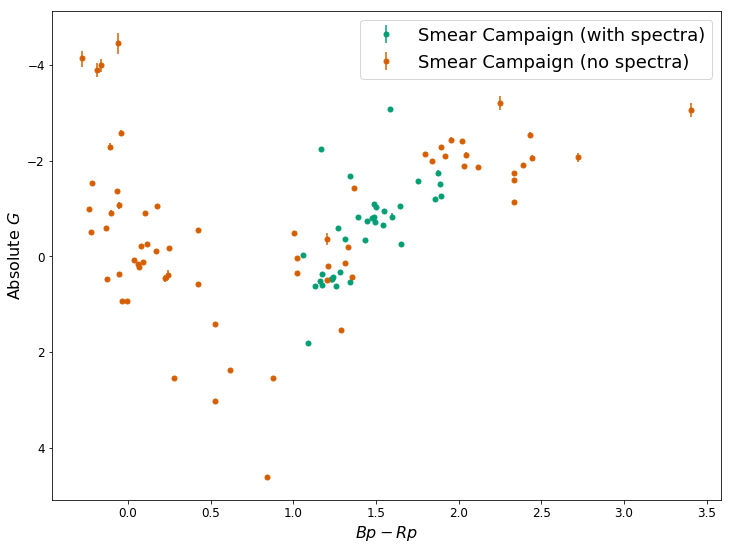

In [59]:
rc('text', usetex=False)
m = newtab['Spectroscopy']!='--'
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear Campaign (with spectra)',markersize=10)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear Campaign (no spectra)',markersize=10)
plt.gca().invert_yaxis()
plt.xlabel(r'$Bp-Rp$')
plt.ylabel(r'Absolute $G$')
plt.legend()

Now we want to use Megan Bedell's Gaia-Kepler crossmatch to situate these in the broader colour-magnitude diagram

In [60]:
kep_data = Table.read('../data/kepler_dr2_4arcsec.fits', format='fits')


In [61]:
kep_data['abs_gmag'] = kep_data['phot_g_mean_mag'] - \
                            5.*(np.log10(kep_data['r_est']) - 1.)
kep_data['abs_gmag'].unit = u.mag

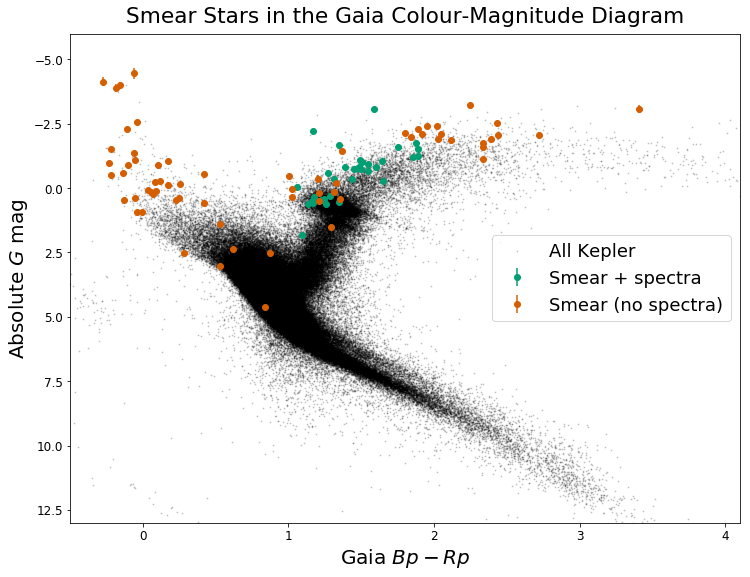

In [90]:
filter = (kep_data['phot_g_mean_mag'] <= 18.) & (kep_data['parallax'] > 0.1)
plt.scatter(kep_data['bp_rp'][filter], kep_data['abs_gmag'][filter], alpha=0.15, color='k', s=1,label='All Kepler')
m = newtab['Spectroscopy']!='--'
plt.errorbar(bp[m]-rp[m],abs_gg[m],yerr=errorbars[:,m],fmt='.',color=colours[1],label=r'Smear + spectra',markersize=12)
plt.errorbar(bp[~m]-rp[~m],abs_gg[~m],yerr=errorbars[:,~m],fmt='.',color=colours[2],label=r'Smear (no spectra)',markersize=12)

plt.xlabel('Gaia $Bp-Rp$', fontsize=20)
plt.ylabel(r'Absolute $G$ mag', fontsize=20)
plt.ylim([13,-6])
plt.xlim([-0.5,4.1])
plt.legend()
plt.title(r'Smear Stars in the Gaia Colour-Magnitude Diagram',y=1.01)
plt.savefig('../paper/gaia_kepler_hr.png')